# Generación de un modelo a partir de uno modelo pre-entrenado
---
**Montar la carpeta de Google Drive y definir constantes para trabajar**

In [4]:
MNT_DRIVE_DIR = '/content/drive/'
DRIVE_DIR = '/content/drive/MyDrive/'
DATOS_DIR = DRIVE_DIR + 'Datos/'
FUENTES_DIR = '/content/drive/MyDrive/Colab Notebooks/Fuentes'

from google.colab import drive
drive.mount(MNT_DRIVE_DIR)

# agrega ruta de busqueda donde tenemos archivos .py
import sys
sys.path.append(FUENTES_DIR)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


---
**Preparación de Dataset**

11490434/11490434 [==============================] - 0s 0us/step


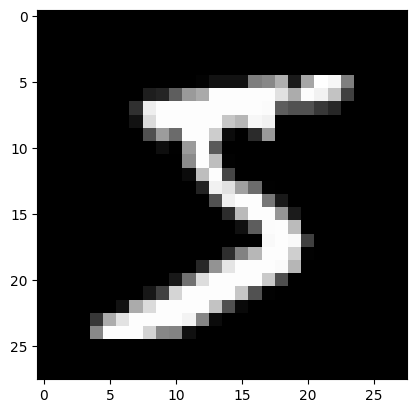

In [5]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical

from sklearn import metrics
import seaborn as sns

import  matplotlib.pyplot as plt
import numpy as np

# %% Carga y perparación de datos de entrenamiento y testeo

(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

Y_train= to_categorical(np.array(Y_train))
Y_test = to_categorical(np.array(Y_test))

# dimension de las imagenes sacadas del primer ejmeplo
IMG_SHAPE = X_train[0].shape # (28,28)
TARGET_CNT= len(Y_train[0])  # 10 dígitos/clases

# nro. de imagen a visualizar
plt.imshow(X_train[0, :,:], cmap='gray')

# normalización
X_train = X_train / 255
X_test  = X_test  / 255

**Generación del Modelo**

In [61]:
# %% Construccion del modelo
model = Sequential()

'''model.add(Conv2D(16, kernel_size=(3,3), strides=(2,2), activation='relu', input_shape=[*IMG_SHAPE, 1] ))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(16, kernel_size=(3,3), strides=(2,2), activation='relu' ))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(20, activation='relu'))
model.add(Dense(TARGET_CNT, activation='softmax'))

'''
model.add(Conv2D(64, kernel_size=(3,3), strides=(2,2), activation='relu', input_shape=[*IMG_SHAPE, 1] ))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, kernel_size=(3,3), strides=(2,2), activation='relu' ))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(100, activation='leaky_relu'))
model.add(Dense(TARGET_CNT, activation='softmax'))


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'] )

model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 13, 13, 64)        640       
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 6, 6, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_28 (Conv2D)          (None, 2, 2, 64)          36928     
                                                                 
 max_pooling2d_23 (MaxPooli  (None, 1, 1, 64)          0         
 ng2D)                                                           
                                                                 
 flatten_6 (Flatten)         (None, 64)                0         
                                                                 
 dense_12 (Dense)            (None, 100)             

**Entrenamiento del Modelo**

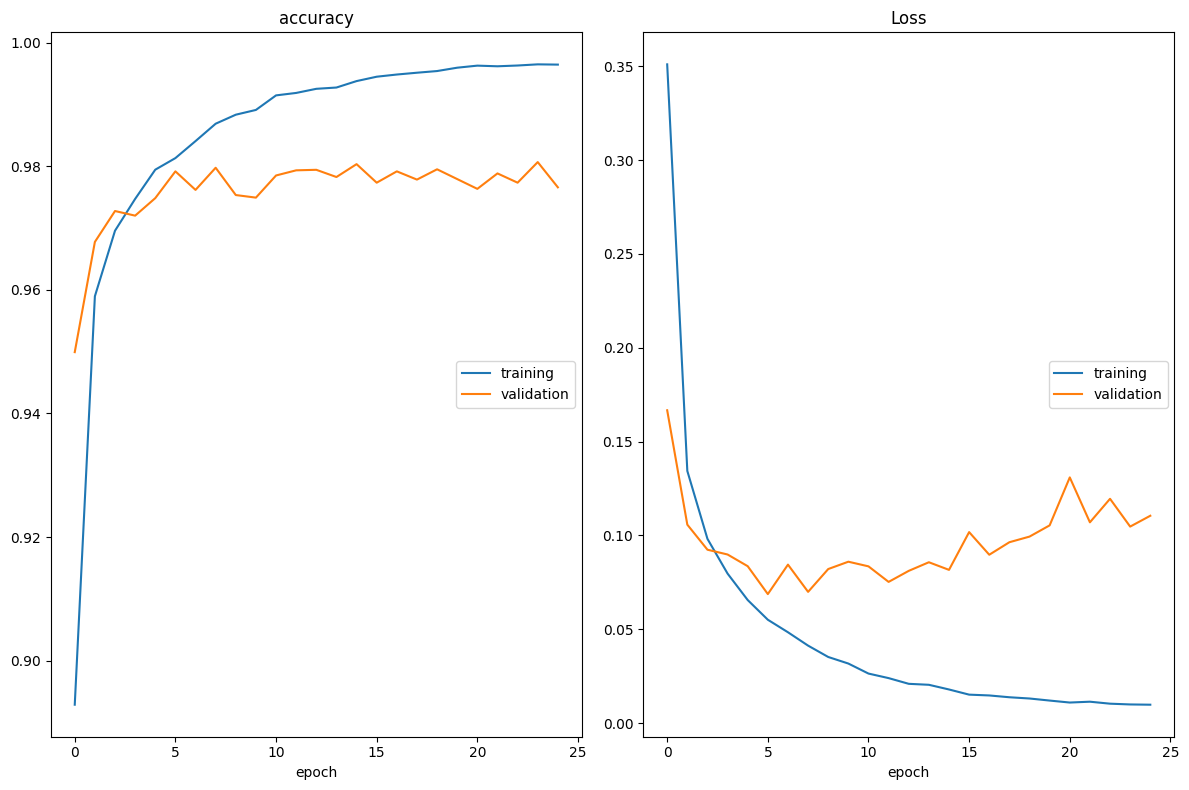

accuracy
	training         	 (min:    0.893, max:    0.996, cur:    0.996)
	validation       	 (min:    0.950, max:    0.981, cur:    0.977)
Loss
	training         	 (min:    0.010, max:    0.351, cur:    0.010)
	validation       	 (min:    0.069, max:    0.167, cur:    0.111)
(60000, 28, 28)
1875/1875 [==============================] - 4s 2ms/step

Efectividad del modelo con datos de entrenamiento:  99.35%
Efectividad del modelo con datos de Prueba.......:  97.78%


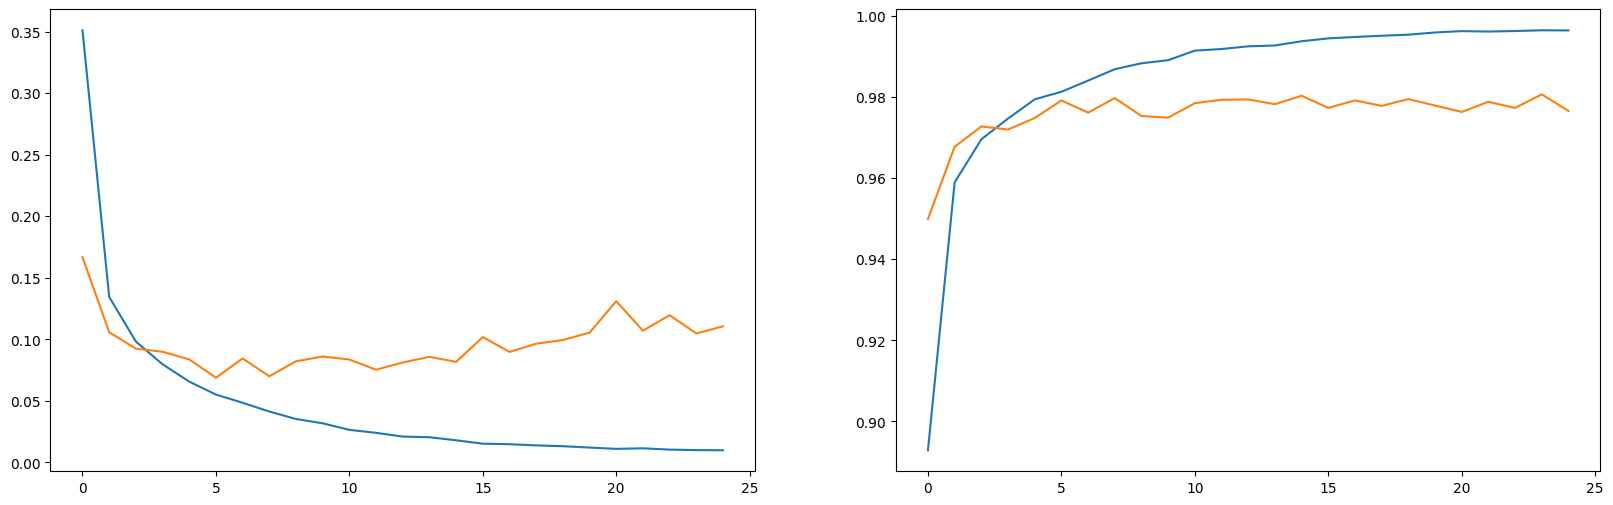

<Figure size 640x480 with 0 Axes>

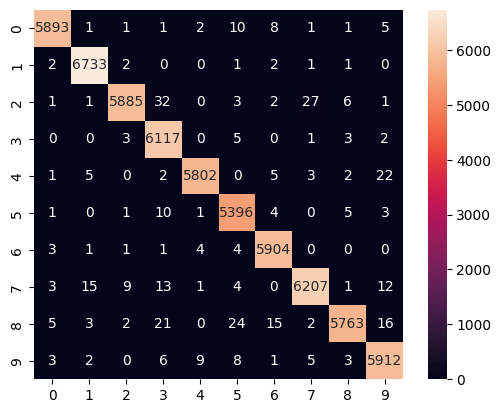

In [62]:
!pip install livelossplot --quiet

LOTES  = 32
EPOCAS = 25

from livelossplot import PlotLossesKeras

# %% Entrenamiento del modelo usando datos de entrenamiento y validacion
H = model.fit(x=X_train, y=Y_train, batch_size=LOTES,
              epochs=EPOCAS, validation_split=0.2, callbacks=[PlotLossesKeras()], verbose=0)


fig, axs = plt.subplots(1,2, figsize=(20,6))
plt.figure()
axs[0].plot(H.history["loss"], label="train_loss")
axs[0].plot(H.history["val_loss"], label="val_loss")

axs[1].plot(H.history["accuracy"], label="train_acc")
axs[1].plot(H.history["val_accuracy"], label="val_acc")


print (X_train.shape)
pred = model.predict(X_train)

cm = metrics.confusion_matrix(np.argmax(Y_train, axis=1), np.argmax(pred, axis=1))
plt.figure()
sns.heatmap(cm, square=True,  annot=True, fmt='d')


# %% evalua el modelo para entrenamiento y testeo
pred = model.evaluate(X_train, Y_train, verbose=0)
print("\nEfectividad del modelo con datos de entrenamiento: %6.2f%%" % (pred[1]*100))

# evalua el modelo con los datos de validacion
pred = model.evaluate(X_test, Y_test, verbose=0)
print("Efectividad del modelo con datos de Prueba.......: %6.2f%%" % (pred[1]*100))

**Salva modelo entrenado para recuperarlo luego**

In [ ]:
model.save('MNIST_conv_model.h5')

**Recupera modelo guardado**


In [ ]:
from tensorflow.keras.models import load_model

model = load_model('MNIST_conv_model.h5')

**Abre panel de dibujo y realiza prediccion**

In [ ]:
import numpy as np
from ClassDrawPanel import DrawPanel
from PIL import Image, ImageOps

IMG_SHAPE=(28,28)

dp = DrawPanel()
image = dp.draw(size=IMG_SHAPE, line_width=2.0, scale = 5)

# obtiene canal de dibujo y normaliza a [0, 1]
gs_image = np.array(image)[:,:,3]/255

# prepara formato para funcion de prediccion
gs_image = gs_image.reshape(1,*IMG_SHAPE,1)

# obtiene salida (sofmax)
resp = model.predict(gs_image, verbose=0)

# posición de la neurona de salida con mayor valor
digito = np.argmax(resp)

print("El trazo dibujado corresponde al dígito %d" % digito)
